In [7]:
import cv2
import tensorflow as tf
import pandas as pd
import json
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm 
import albumentations as A
import os
import random
import numpy as np


### Convert Data into csv 

In [2]:
"""
folders=os.listdir("data")# rooy path where the data is present
root_dir="data"
video_paths=[]
labels=[]
for folder in folders:
    folder_path=os.path.join(root_dir,folder)
    for filename in os.listdir(folder_path):
        label=filename.split("_")[1]
        video_path=os.path.join(folder_path,filename)
        video_paths.append(video_path)
        labels.append(label)
    

data_csv=pd.DataFrame()
data_csv["paths"]=video_paths
data_csv["labels"]=labels

data_csv.to_csv("total_data.csv",index=False)
"""

In [3]:
data_csv=pd.read_csv("total_data.csv")

### map the labels to numbers

In [4]:
unique_labels=data_csv["labels"].unique()

print(unique_labels)
labels_dict={}
for idx,label in enumerate(unique_labels):
    labels_dict[label]=idx

with open("labeldict","w") as fp:
    json.dump(fp)

with open("labeldict","r") as fp:
    labels_dict=json.load(fp)

In [36]:
print('following are the 40 classes used for training :',labels_dict.keys())

following are the 40 classes used for training : dict_keys(['BoxingPunchingBag', 'HandStandPushups', 'FieldHockeyPenalty', 'BreastStroke', 'FrisbeeCatch', 'Archery', 'ApplyLipstick', 'Basketball', 'BaseballPitch', 'BandMarching', 'BalanceBeam', 'FloorGymnastics', 'ApplyEyeMakeup', 'Biking', 'FrontCrawl', 'HandstandWalking', 'BabyCrawling', 'BasketballDunk', 'BlowingCandles', 'CleanAndJerk', 'HighJump', 'HeadMassage', 'BenchPress', 'CricketBowling', 'Hammering', 'BrushingTeeth', 'Drumming', 'Fencing', 'GolfSwing', 'CliffDiving', 'CricketShot', 'BoxingSpeedBag', 'HammerThrow', 'CuttingInKitchen', 'Bowling', 'BlowDryHair', 'Diving', 'BodyWeightSquats', 'Haircut', 'Billiards'])


In [37]:
invers_map={}

for key in labels_dict.keys():
    value=labels_dict[key]
    invers_map[value]=key

In [5]:
%matplotlib inline

### Create Dataset class for providing data to model



In [8]:

# use cut out augmentaion in training beacause there are backgrounds in videos we need to make sure that model ignores them while training
# 30 % of data in training is transformed using cutout 

cutout_augmentation = A.Compose([
    A.Cutout(num_holes=1, max_h_size=30, max_w_size=30, always_apply=True,p=1.)
  

])

In [9]:

def convert_to_frames(video,aug,training=True,length=15):

    frames=[]
    count=0
    frame_count=0
    random_number = random.random()
    val=random_number>0.3
    while True:
        try :

            ret ,frame=video.read()
            if ret:
                
                frame=cv2.resize(frame,(224,224)) 
                
                
                if training and val:
                    transform=aug(image=frame)
                    frame=transform["image"]
                    
                if frame_count%15 ==0:
                    count+=1
                    if count<=length:
                        frames.append(frame)
                    else:
                        frames=np.array(frames)
                        return frames
            else:
                break
        
        except :
            pass
        frame_count+=1
    if count<length:
        for _ in range(length-len(frames)):
            dummys=np.zeros(shape=(224,224,3))
            frames.append(dummys)

    frames=np.array(frames)
    return frames

class Dataset:
    def __init__(self,paths,labels,batch_size=4,aug=None):
        self.paths=paths
        self.labels=labels
        self.batch_size=batch_size
        self.num_samples = len(self.labels)
        self.num_batchs = int(np.ceil(self.num_samples / self.batch_size))
        self.batch_count = 0
        self.aug=aug

    def __iter__(self):
        return self
    def process_data(self,video_path,label,aug):

        video=cv2.VideoCapture(video_path)
        if aug is not None:
        
            frames= convert_to_frames(video,aug,training=True)
        else:
            frames= convert_to_frames(video,aug,training=False)
        Label=tf.one_hot(label,40)
  

      

        return frames,Label

        
    def __next__(self):
        num=0
        if self.batch_count<self.num_batchs:
            batch_frames=[]
            batch_labels=[]
            while num<self.batch_size:
                index=self.batch_count*self.batch_size+num
                try:
                    video_path=self.paths[index]
                    label=self.labels[index]
                except:
                    self.batch_count = 0
                    indices=list(range(len(self.paths)))
                    random.shuffle(indices)
                    paths=[self.paths[i] for i in indices]
                    labels=[self.labels[i] for i in indices]
                    self.paths=paths
                    self.labels=labels
                    raise StopIteration

                frames,label=self.process_data(video_path=video_path,label=label,aug=self.aug)
               
                
                frames=frames/255.

                frames=tf.constant(frames, dtype=tf.float32)
                label=tf.constant(label, dtype=tf.float32)
                num+=1
                batch_frames.append(frames)
                batch_labels.append(label)

            frames_batch=tf.stack(batch_frames,axis=0)
            labels_batch=tf.stack(batch_labels,axis=0)
            self.batch_count+=1
            return(frames_batch,labels_batch)
        else:
            self.batch_count = 0
          
            indices=list(range(len(self.paths)))
            random.shuffle(indices)
            paths=[self.paths[i] for i in indices]
            labels=[self.labels[i] for i in indices]
            self.paths=paths
            self.labels=labels
            
            raise StopIteration
        
    def __len__(self):
        return self.num_batchs

In [10]:
labels=list(data_csv["labels"].map(labels_dict).values)




paths=list(data_csv["paths"].values)
#split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(paths,labels, test_size=0.15,stratify=labels,random_state=42)

#make the train and test data into model readble inputs with datset

train_dataset=Dataset(paths=X_train,labels=y_train,aug=cutout_augmentation)
valid_dataset=Dataset(paths=X_test,labels=y_test)


### Plot of Two videos with Captions

In [48]:
def get_image(video_path):

    video=cv2.VideoCapture(video_path)
    while True:
        ret,frame=video.read()
        if ret:
            frame=cv2.resize(frame,(224,224))
        break
    return frame

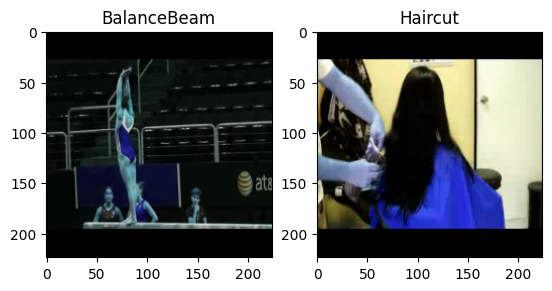

In [50]:
count=0
for idx,video_path in enumerate(X_train):
    frame=get_image(video_path=video_path)
    label=invers_map[y_train[idx]]
    if idx>=2:
        break
    plt.subplot(1,2,idx+1)
    plt.imshow(frame)
    plt.title(label)
    

### Model Building
    1) Model is made of two parts encoder and decoder
    2) encoder containes pretrained mobile net model for feature extraction and final layer is average pool of final conv layers output
    3) encoder takes 15 frames from video sampled at 2 fps .encoder processes each frame and converts into 1024 dimensional vector
    4) Decoder contains two main custom layers temporal attention and spatial attention .
    5) temporal attention layer takes 15 * 1024 dimesnion vector as input and it has lstm layer and Dense layers with softmax attention over 15 
       time stamps to filter out correlated frames information or frames which doesn't contribute to classification.
    6) spatial attention layer takes 1024 * 15 dimensional vector as input (tranpose of out put of encoder) and perform spatial attention over 1024 
       dimensions to eliminate background information from frame reciptive field.
    7) both out puts of temporal and spatial attention layers are added and processed with dense layer to filter out time dimension.
    8) final layer is dense layer with 40 neurons  with softmax actiavtion as we are considering 40 classes to predict.
    9) except for mobilenet layers,lstm layers,final layer all other layers activation are mish. as mish provides smooth gradients and 
      doesnt have dieing neuron problem like relu .
    10) batch normalization layers are applied accross all the layers for faster convergence of model while training.


In [11]:
### Layer Helpers

def mish(x):
    return x * tf.math.tanh(tf.math.log(1 + tf.math.exp(x)))

mob_model=tf.keras.applications.mobilenet.MobileNet(
    input_shape=(224,224,3),
    alpha=1.0,
    depth_multiplier=1,
    dropout=0.1,
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    pooling="avg",
    classes=1000,
    classifier_activation='softmax',
)
class ExtratFeat(tf.keras.layers.Layer):
  def __init__(self,):
    super(ExtratFeat, self).__init__()

    self.feat_extractor=mob_model

  def call(self,inputs):

    return self.feat_extractor(inputs)
  
class Encoder(tf.keras.layers.Layer):
  def __init__(self,):
    super(Encoder, self).__init__()
    self.extact=ExtratFeat()


  def call(self, inputs):
    outs=[]
    for input in inputs:
      out=self.extact(input)
      outs.append(out)

    final_out=tf.stack(outs,axis=0)
    
    return final_out
class TemporalAttention(tf.keras.layers.Layer):
  def __init__(self,):
    super(TemporalAttention, self).__init__()
    self.lstm1=tf.keras.layers.LSTM(
                                      512,
                                      activation="tanh",
                                      recurrent_activation="sigmoid",
                                      use_bias=True,
                                      kernel_initializer="glorot_uniform",
                                      recurrent_initializer="orthogonal",
                                      bias_initializer="zeros",
                                      unit_forget_bias=True,
                                      return_sequences=True
                                  )
    self.dense1=tf.keras.layers.Dense(
                                  512,
                                  activation=None,
                                  use_bias=True,
                                  kernel_initializer='glorot_uniform',
                                  bias_initializer='zeros',
                                  kernel_regularizer="l2",
                                  bias_regularizer=None,
                                  activity_regularizer=None,
                                  kernel_constraint=None,
                                  bias_constraint=None,
                              )
    self.denseatt=tf.keras.layers.Dense(
                                  1,
                                  activation=None,
                                  use_bias=True,
                                  kernel_initializer='glorot_uniform',
                                  bias_initializer='zeros',
                                  kernel_regularizer="l2",
                                  bias_regularizer=None,
                                  activity_regularizer=None,
                                  kernel_constraint=None,
                                  bias_constraint=None,
                              )
  
    self.bn1=tf.keras.layers.BatchNormalization(
    axis=-1,
    momentum=0.99,
    epsilon=0.001,
    center=True,
    scale=True,
    beta_initializer='zeros',
    gamma_initializer='ones',
    moving_mean_initializer='zeros',
    moving_variance_initializer='ones',
    beta_regularizer=None,
    gamma_regularizer=None,
    beta_constraint=None,
    gamma_constraint=None,
    synchronized=False,
    
          )
    
  def call(self,inputs,training=True):
    out=self.lstm1(inputs)
    out=self.dense1(out)
    out=self.bn1(out,training=training)
    out=mish(out)
    att=self.denseatt(out)
    att=tf.nn.softmax(att,axis=2, name='alpha_ij')
    final_out=inputs*att
    return final_out


class SpatialAttention(tf.keras.layers.Layer):
  
  def __init__(self,):
    super(SpatialAttention, self).__init__()

    self.dense=tf.keras.layers.Dense(
                                  1,
                                  activation=None,
                                  use_bias=True,
                                  kernel_initializer='glorot_uniform',
                                  bias_initializer='zeros',
                                  kernel_regularizer="l2",
                                  bias_regularizer=None,
                                  activity_regularizer=None,
                                  kernel_constraint=None,
                                  bias_constraint=None,
                              )
  def call(self,inputs):
    out=self.dense(inputs)
    att=tf.nn.softmax(out,axis=2, name='alpha_ij')
    final_out=inputs*att
    return final_out



In [13]:
### Action Model

class ActionModel(tf.keras.Model):
  def __init__(self,):
    super(ActionModel, self).__init__(name='')
    self.encoder=Encoder()
    self.temporal_Att=TemporalAttention()
    self.spatial_Att=SpatialAttention()
    self.densefinal=tf.keras.layers.Dense(
                                  1,
                                  activation=None,
                                  use_bias=True,
                                  kernel_initializer='glorot_uniform',
                                  bias_initializer='zeros',
                                  kernel_regularizer="l2",
                                  bias_regularizer=None,
                                  activity_regularizer=None,
                                  kernel_constraint=None,
                                  bias_constraint=None,
                              )
    self.bnfinal=tf.keras.layers.BatchNormalization(
    axis=-1,
    momentum=0.99,
    epsilon=0.001,
    center=True,
    scale=True,
    beta_initializer='zeros',
    gamma_initializer='ones',
    moving_mean_initializer='zeros',
    moving_variance_initializer='ones',
    beta_regularizer=None,
    gamma_regularizer=None,
    beta_constraint=None,
    gamma_constraint=None,
    synchronized=False,
    
          )
    self.classlayer=tf.keras.layers.Dense(
                                  40,
                                  activation="softmax",
                                  use_bias=True,
                                  kernel_initializer='glorot_uniform',
                                  bias_initializer='zeros',
                                  kernel_regularizer="l2",
                                  bias_regularizer=None,
                                  activity_regularizer=None,
                                  kernel_constraint=None,
                                  bias_constraint=None,
                              )

  def call(self,inputs,training=True):
    out=self.encoder(inputs)

    input_spatial=tf.transpose(out, [0, 2, 1])

    temp_out=self.temporal_Att(out,training=training)
    spatial_out=self.spatial_Att(input_spatial)
    out_temp=tf.transpose(temp_out, [0, 2, 1])

    gather_out=spatial_out+out_temp

    linear1=self.densefinal(gather_out)
    linear1=self.bnfinal(linear1,training=training)
    linear1out=mish(linear1)
    linear1out=tf.squeeze(linear1out,axis=-1)
    



    finallogits=self.classlayer(linear1out)
    return finallogits
  
model=ActionModel()

### Training

    1) cross entropy loss is used .
    2) adam optimizer with default learning rate(0.001) is used. as adam dimnishes over fluctuations of gradients in wrong direction
       and makes gradients higher in the required direction to make model to reach optimum quickly.
    3) deafult learning rate is used as pretrained feature extractor used is initialized with image net wieghts and also
       as adam is used it takes care of gradient fluctuations.

    4) model is trained for 10 epochs
    

In [33]:
tf.config.list_physical_devices('GPU')


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [14]:
#train model

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
# Instantiate a loss function.
loss_fn = tf.keras.losses.CategoricalCrossentropy()


valid_loss= tf.keras.losses.CategoricalCrossentropy()

train_acc_metric = tf.keras.metrics.CategoricalAccuracy(
    name='categorical_accuracy', dtype=None
)

val_acc_metric = tf.keras.metrics.CategoricalAccuracy(
    name='categorical_accuracy_valid', dtype=None
)



epochs = 10
train_losses=[]
valid_losses=[]
train_accuracies=[]
valid_accuracies=[]

for epoch in range(epochs):
    print("\nStart of epoch %d" % (epoch,))
    for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):

        with tf.GradientTape() as tape:
            logits = model(x_batch_train, training=True)
            loss_value = loss_fn(y_batch_train, logits)
        grads = tape.gradient(loss_value, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))

        # Update training metric.
        train_acc_metric.update_state(y_batch_train, logits)
        #progress_bar.set_description(f'Epoch {epoch + 1}/{10}, step {step + 1}/{1207} ,Loss: {loss_value:.4f}')
        # print("losss :",float(loss_value))
        if (step%500)==0:
            train_losses.append(float(loss_value))
            print("loss ",float(loss_value))
    train_acc = train_acc_metric.result()
    train_accuracies.append(train_acc)
    
    train_acc_metric.reset_states()
 
    for val_step,(x_batch_val, y_batch_val) in enumerate(valid_dataset):
        val_logits = model(x_batch_val)
        val_loss_value = valid_loss(y_batch_val,val_logits)
        
        
        if (val_step % 65) ==0:
            print("val loss",val_loss_value)
            valid_losses.append(float(val_loss_value))
    # Update val metrics
        val_acc_metric.update_state(y_batch_val, val_logits)
    val_acc = val_acc_metric.result()
    valid_accuracies.append(val_acc)
    print("Validation acc: %.4f" % (float(val_acc),))

    if ((epoch+1)%2)==0:
        model.save_weights("/home/chanukya/Downloads/actionrecognition/wts/cuta_"+str(float(val_acc))+"_"+str(float(val_loss_value))+"_.h5")
    val_acc_metric.reset_states()
    
    


    


Start of epoch 0


2023-09-14 18:03:26.230315: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8904
2023-09-14 18:03:26.928029: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-09-14 18:03:27.643328: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55ee12e12010 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-09-14 18:03:27.643351: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2023-09-14 18:03:27.648029: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-09-14 18:03:27.714488: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifeti

loss  4.386209487915039
loss  3.319192409515381
loss  4.014604568481445
val loss tf.Tensor(2.560993, shape=(), dtype=float32)
val loss tf.Tensor(1.735404, shape=(), dtype=float32)
val loss tf.Tensor(3.0147552, shape=(), dtype=float32)
val loss tf.Tensor(3.0716224, shape=(), dtype=float32)
Validation acc: 0.3296

Start of epoch 1
loss  2.866007089614868
loss  1.5559499263763428
loss  1.2384542226791382
val loss tf.Tensor(1.8755505, shape=(), dtype=float32)
val loss tf.Tensor(2.624846, shape=(), dtype=float32)
val loss tf.Tensor(2.7147436, shape=(), dtype=float32)
val loss tf.Tensor(1.5452948, shape=(), dtype=float32)
Validation acc: 0.5062

Start of epoch 2
loss  0.5374962091445923
loss  2.267810821533203
loss  0.12772303819656372
val loss tf.Tensor(1.6966795, shape=(), dtype=float32)
val loss tf.Tensor(0.8411831, shape=(), dtype=float32)
val loss tf.Tensor(1.1136074, shape=(), dtype=float32)
val loss tf.Tensor(3.310742, shape=(), dtype=float32)
Validation acc: 0.6741

Start of epoch 3


In [22]:
print("total training time taken is ",80 ,"mins")

total training time taken is  80 mins


### Loss Plots

Text(0.5, 1.0, 'valid loss')

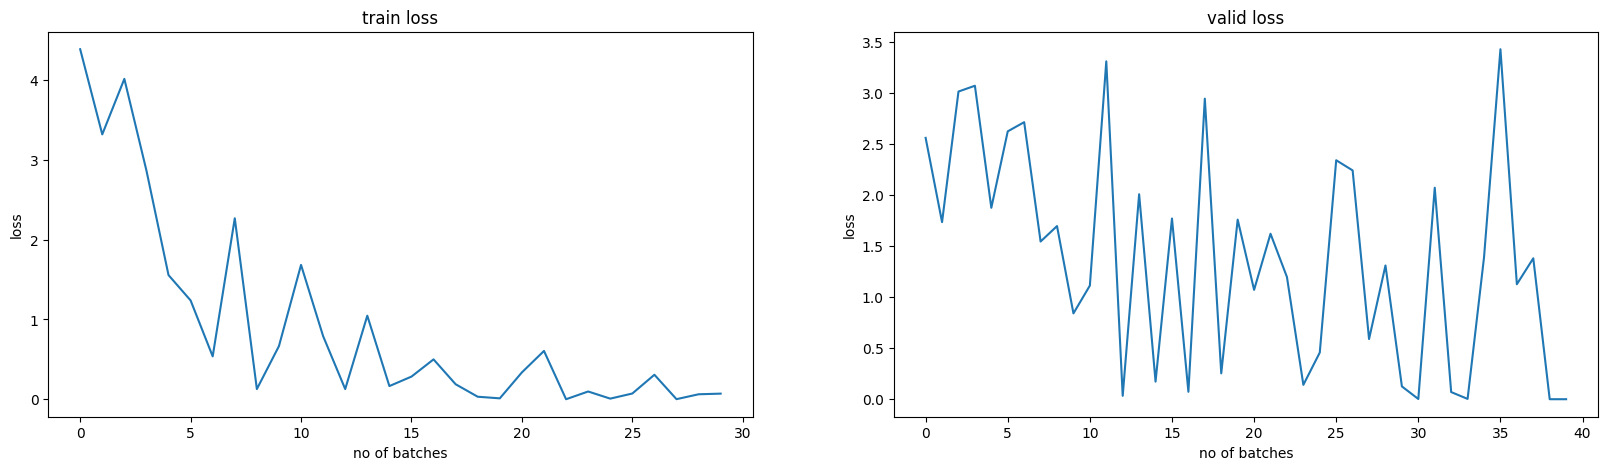

In [19]:
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
plt.plot(train_losses)
plt.xlabel("no of batches")
plt.ylabel("loss")
plt.title("train loss")

plt.subplot(1,2,2)
plt.plot(valid_losses)
plt.xlabel("no of batches")
plt.ylabel("loss")
plt.title("valid loss")



### Accuracy Plots

Text(0.5, 1.0, 'valid accuracy')

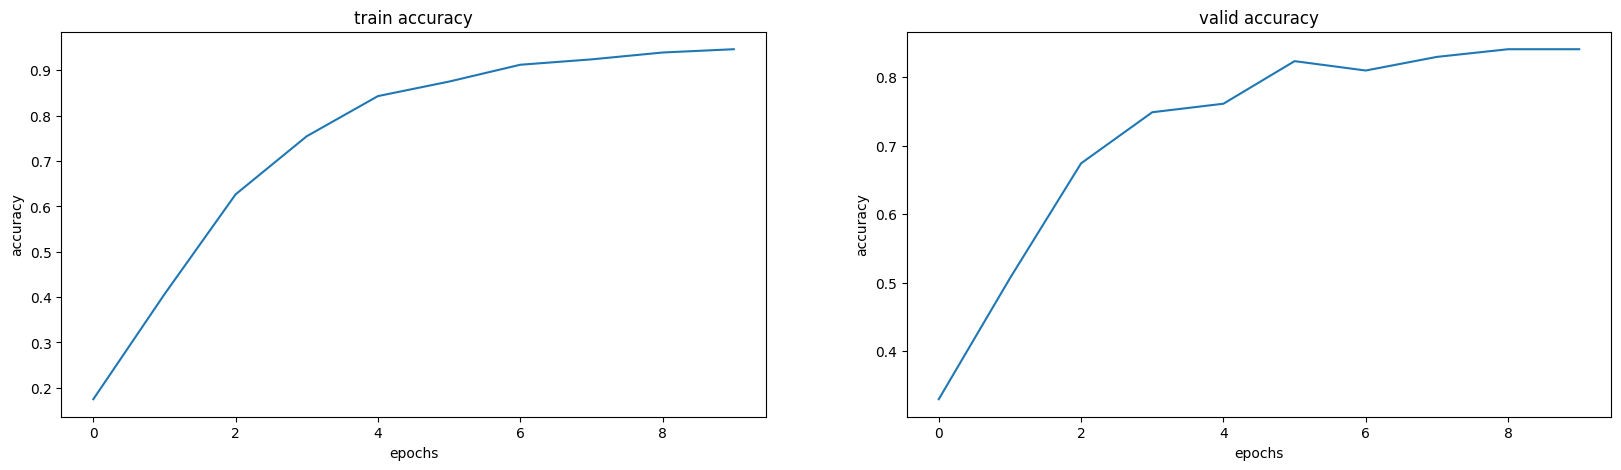

In [20]:
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
plt.plot(train_accuracies)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.title("train accuracy")

plt.subplot(1,2,2)
plt.plot(valid_accuracies)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.title("valid accuracy")

### Confusion Matrix and Classification Reports

In [23]:
def convert_to_frames_infernce(video,length=15):

    frames=[]
    count=0
    frame_count=0
    while True:
        try :

            ret ,frame=video.read()
            if ret:
                
                frame=cv2.resize(frame,(224,224)) 
                    
                if frame_count%15 ==0:
                    count+=1
                    if count<=length:
                        frames.append(frame)
                    else:
                        frames=np.array(frames)
                        return frames
            else:
                break
        
        except :
            pass
        frame_count+=1
    if count<length:
        for _ in range(length-len(frames)):
            dummys=np.zeros(shape=(224,224,3))
            frames.append(dummys)

    frames=np.array(frames)
    return frames

In [26]:
model(tf.random.normal(shape=(1,15,224,224,3)))
model.load_weights("/home/chanukya/Downloads/actionrecognition/wts/cuta_0.8407959938049316_0.08788354694843292_.h5")

In [3]:

def get_preds(test_path):
    video=cv2.VideoCapture(test_path)
    frames=convert_to_frames_infernce(video=video)
    frames=tf.constant(frames,dtype=tf.float32)
    frames=frames/255.
    frames=tf.expand_dims(frames,axis=0)
    preds=model(frames)
    
    return float(tf.math.argmax(preds,axis=-1))

In [28]:
test_preds=[]
for test_path in X_test:
    pred=get_preds(test_path=test_path)
    test_preds.append(pred)

In [29]:
print(test_preds[0],y_test[0])

38.0 38


In [31]:
from sklearn.metrics import confusion_matrix,classification_report

In [32]:
## confusion matrix 

print(confusion_matrix(y_true=y_test,y_pred=test_preds))

[[20  0  0 ...  0  1  0]
 [ 0 15  0 ...  0  1  0]
 [ 0  0 17 ...  0  0  0]
 ...
 [ 0  0  0 ... 15  0  0]
 [ 0  0  0 ...  0 17  0]
 [ 0  0  0 ...  0  0 23]]


In [33]:
print(classification_report(y_true=y_test,y_pred=test_preds))

              precision    recall  f1-score   support

           0       1.00      0.83      0.91        24
           1       0.79      0.79      0.79        19
           2       0.94      0.89      0.92        19
           3       0.93      0.87      0.90        15
           4       0.69      0.95      0.80        19
           5       0.84      0.95      0.89        22
           6       0.88      0.88      0.88        17
           7       1.00      0.65      0.79        20
           8       0.90      0.86      0.88        22
           9       1.00      0.78      0.88        23
          10       0.72      0.81      0.76        16
          11       0.94      0.79      0.86        19
          12       0.91      0.91      0.91        22
          13       0.95      0.90      0.92        20
          14       0.95      0.90      0.93        21
          15       0.75      0.71      0.73        17
          16       0.75      0.90      0.82        20
          17       0.90    

### Random infernce of Test Predictions


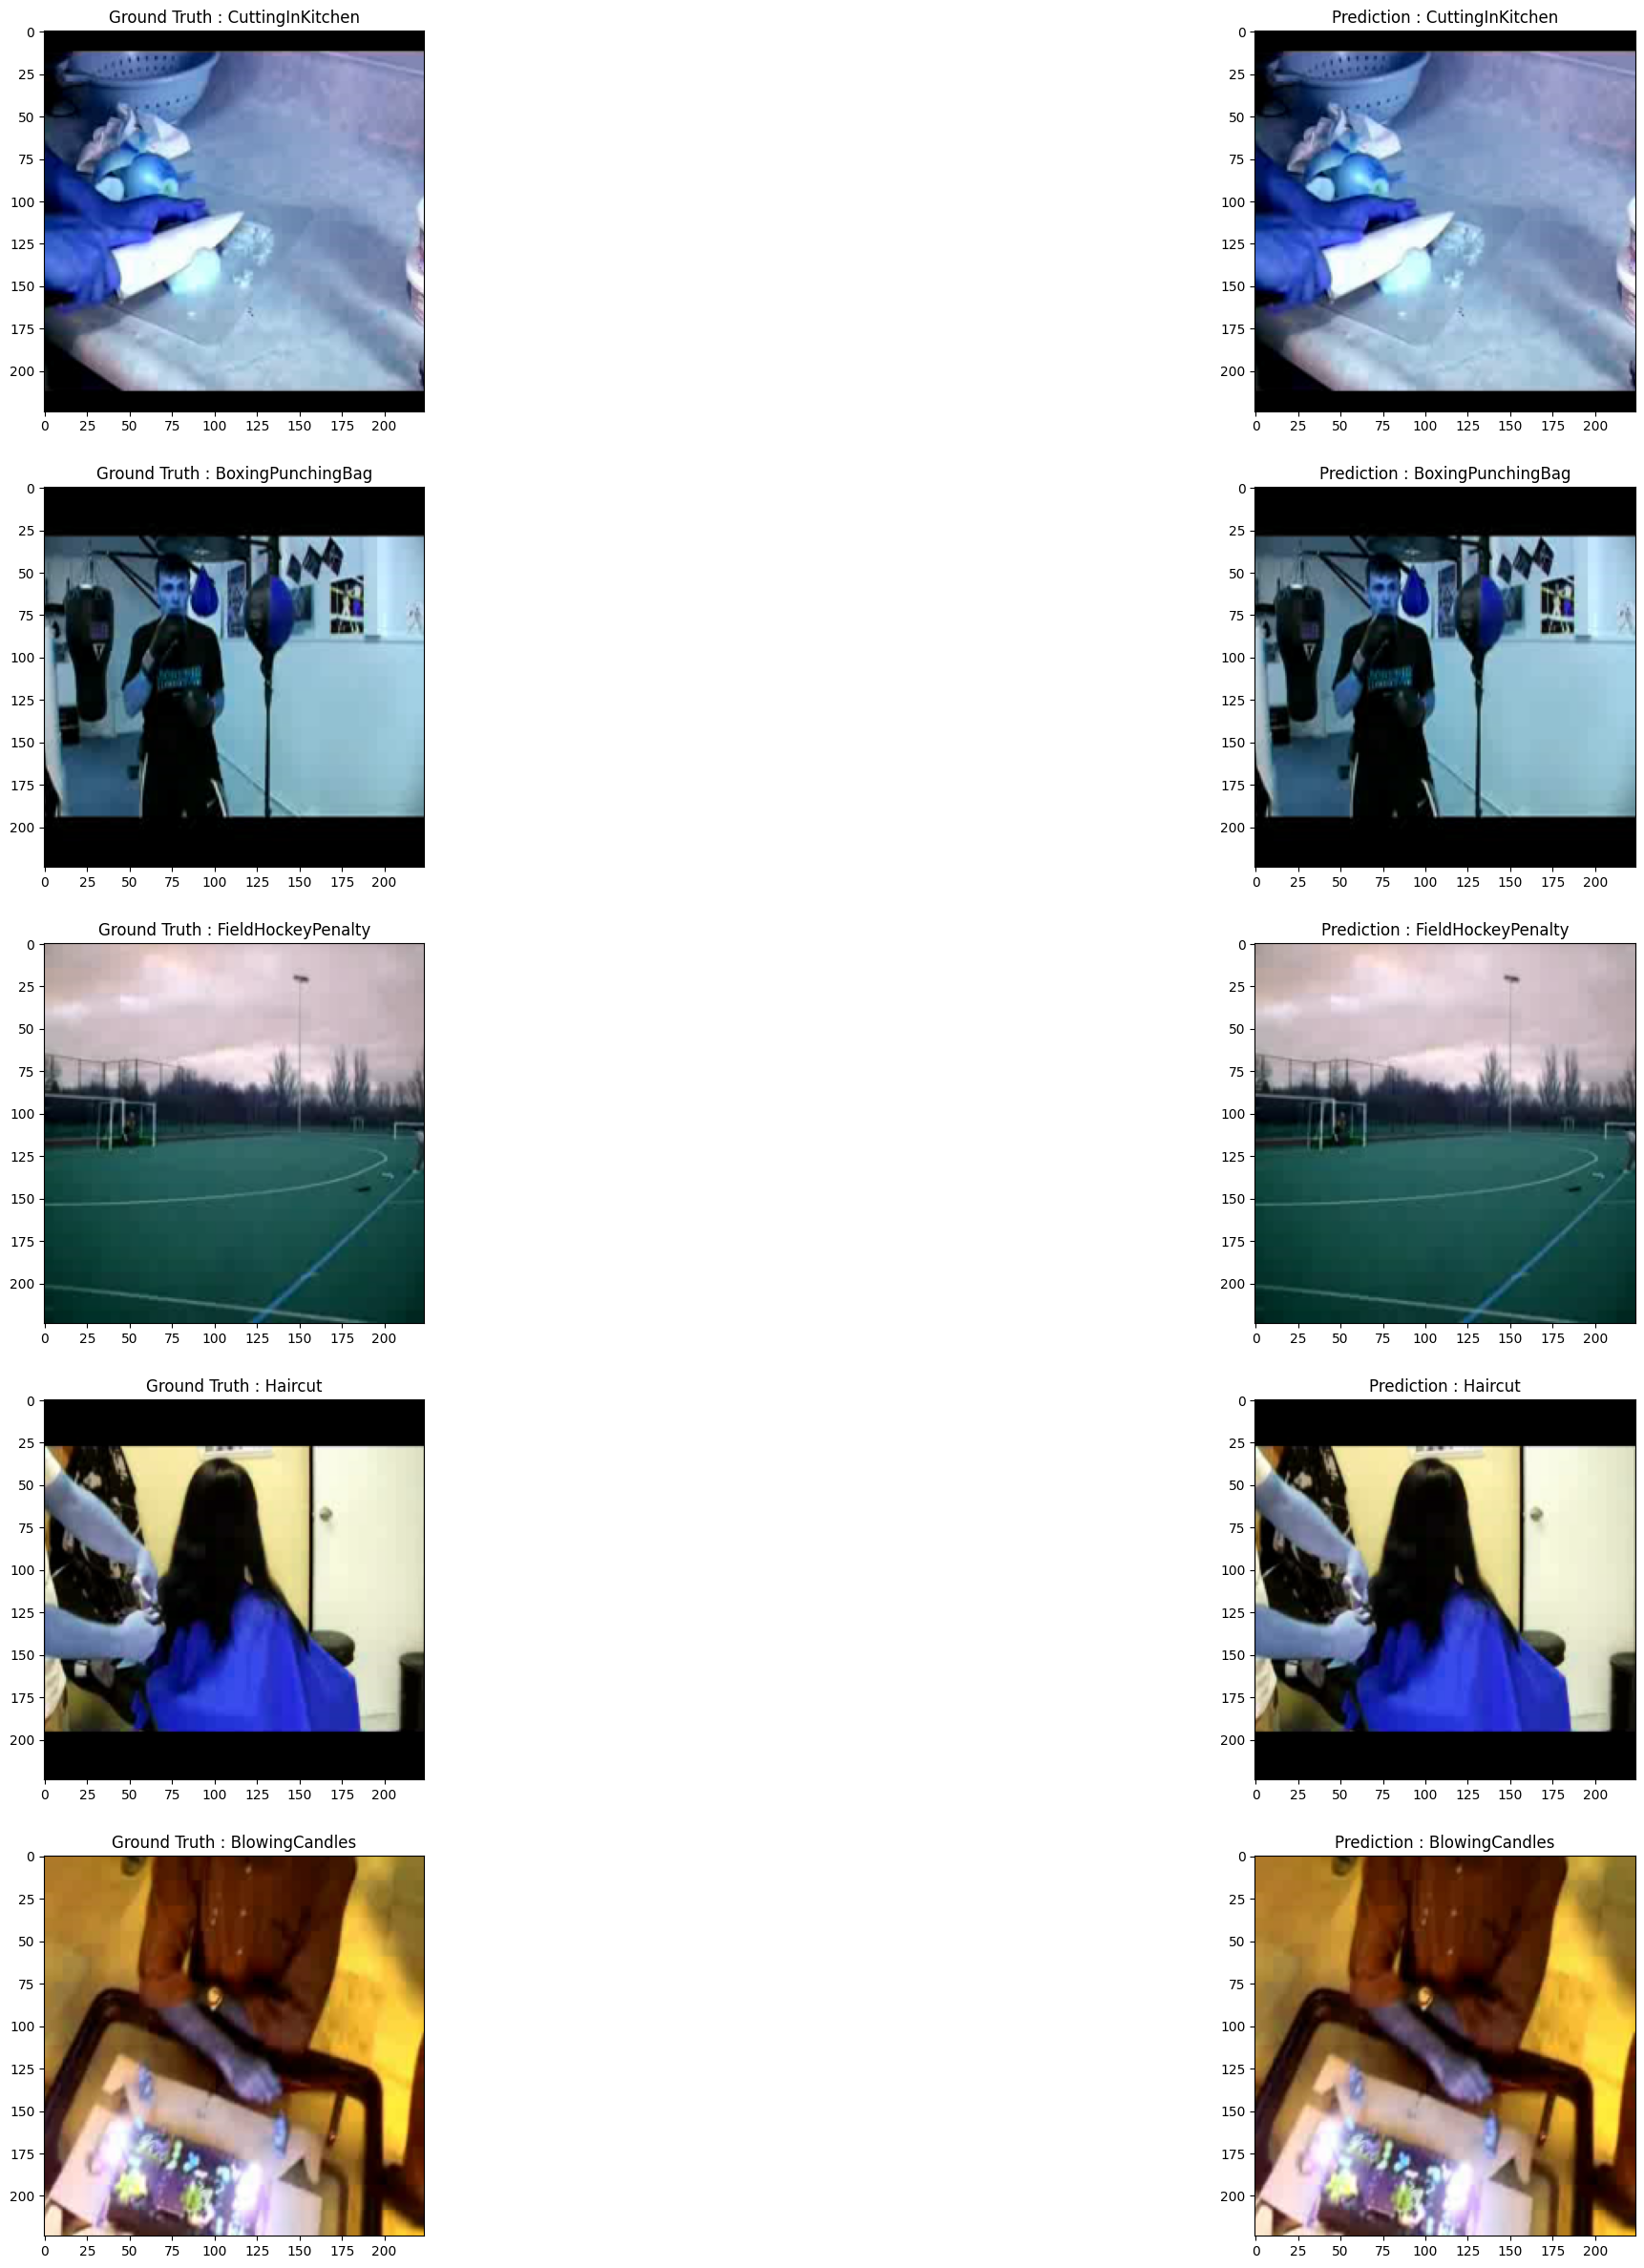

In [53]:
test_indices=list(range(len(X_test)))

random_5_indeces=random.sample(test_indices, 5)

plt.figure(figsize=(30,30))
count=1

for idx in random_5_indeces:

    test_path=X_test[idx]
    true_label=y_test[idx]
    frame=get_image(test_path)
    pred=get_preds(test_path=test_path)
    
    plt.subplot(5,2,count)
    count+=1
    plt.imshow(frame)
    plt.title(f"Ground Truth : {invers_map[true_label]}")
    plt.subplot(5,2,count)
    plt.imshow(frame)
    plt.title(f"Prediction : {invers_map[pred]}")
    count+=1